In [1]:
import numpy as np
import astropy.table
import astropy.units as u

import matplotlib
import matplotlib.pyplot as plt

import lsst.daf.butler
import lsst.afw.display
import lsst.afw.math

import os
# os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"
# del os.environ["RUBIN_SIM_DATA_DIR"]
import rubin_sim.phot_utils
# import time

In [2]:
lsst.afw.display.setDefaultBackend("firefly")
display = lsst.afw.display.Display(backend="firefly")

In [44]:
tract = (453, 454, 531, 532)
center = (6.0230792, -72.0814444)
radius = 14.2*u.arcmin
modulus = 13.24

In [4]:
butler=lsst.daf.butler.Butler("dp1", collections="LSSTComCam/DP1")

# Catalogs

Get the object tables for all the tracts.

In [168]:
# columns = {"coord_ra", "coord_dec", "deblend_masked", "deblend_nChild", "deblend_failed",
#            "deblend_isolatedParent", "deblend_parentTooBig", "g_psfMag", "r_psfMag", "i_psfMag"}
refs = butler.query_datasets("object", where=f"tract in {tract}")
objects = []
for ref in refs:
    # There aren't so many sources that we can't just get all the columns.
    # objects.append(butler.get(ref, parameters={"columns": columns}))
    objects.append(butler.get(ref))
objects = astropy.table.vstack(objects)
print("total objects in the 47Tuc tracts:", len(objects))

total objects in the 47Tuc tracts: 115493


In [169]:
objects = objects[objects["r_extendedness"] < 0.1]
print("non-extended objects:", len(objects))
objects = objects[np.isfinite(objects["g_psfFlux"]) & np.isfinite(objects["r_psfFlux"]) & np.isfinite(objects["i_psfFlux"])]
print("with finite gri fluxes:", len(objects))

non-extended objects: 25500
with finite gri fluxes: 18872


## Compute dust extinction values for the LSST bands.

Text(0.5, 0, 'ebv')

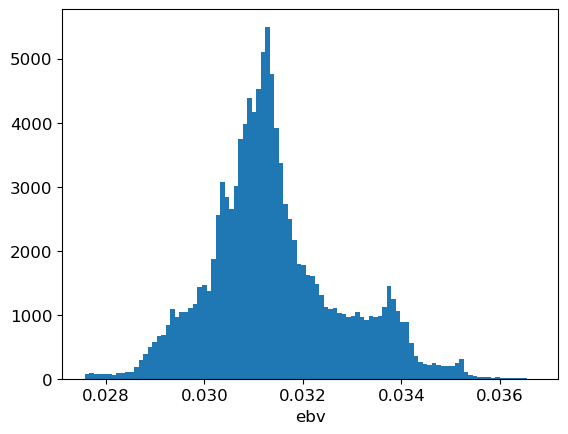

In [24]:
plt.hist(objects['ebv'], bins=100)
plt.xlabel("ebv")

In [172]:
dust = rubin_sim.phot_utils.photometric_parameters.DustValues(ref_ebv=objects['ebv'].mean())

## Some plots of the objects

Text(0, 0.5, 'Dec')

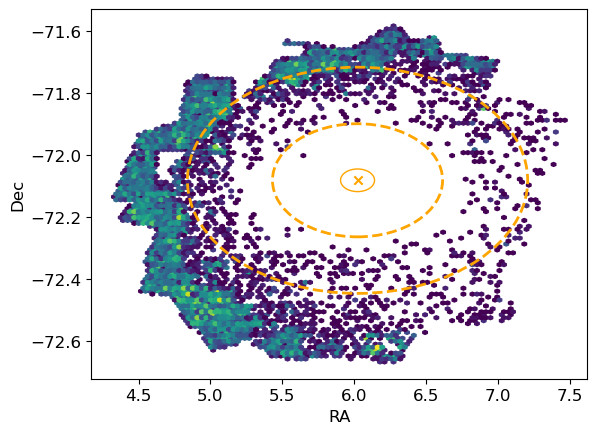

In [187]:
fig, ax = plt.subplots()
# plt.scatter(objects["coord_ra"], objects["coord_dec"], s=1)
plt.hexbin(objects["coord_ra"], objects["coord_dec"], mincnt=1)
plt.scatter(center[0], center[1], marker="x", c="orange")
# TODO: why is the circle an oval? need to do the ra*cos(dec)
ax.add_patch(matplotlib.patches.Ellipse(center, radius.to_value("degree"), radius.to_value("degree")*np.cos(np.deg2rad(center[1])), color="orange", fill=False))
ax.add_patch(matplotlib.patches.Ellipse(center, 5*radius.to_value("degree"), 5*radius.to_value("degree")*np.cos(np.deg2rad(center[1])), color="orange", fill=False, ls="--", lw=2))
ax.add_patch(matplotlib.patches.Ellipse(center, 10*radius.to_value("degree"), 10*radius.to_value("degree")*np.cos(np.deg2rad(center[1])), color="orange", fill=False, ls="--", lw=2))
plt.xlabel("RA")
plt.ylabel("Dec")

In [175]:
# _psfMag doesn't exist in the butler version of this catalog.
flux = "_psfFlux"
mags = {band: (u.nJy*objects[f"{band}{flux}"]).to(u.ABmag) for band in "griy"}

In [176]:
colors = np.array((mags['i'].to_value(u.ABmag),
                   mags['r'].to_value(u.ABmag),
                   mags['g'].to_value(u.ABmag))).T 
# colors = np.nan_to_num(colors)
# colors[colors < 0] = 0
test = (colors[:,0] > 0) & (colors[:,1] > 0) & (colors[:,2] > 0)

In [180]:
colors[:, 0]

array([23.61927001, 21.96097068, 23.06551941, ..., 23.2778635 ,
       23.43045633, 20.57008847], shape=(18872,))

In [183]:
max_band = colors.max(axis=1)
colors[:, 0]/=max_band
colors[:, 1]/=max_band
colors[:, 2]/=max_band

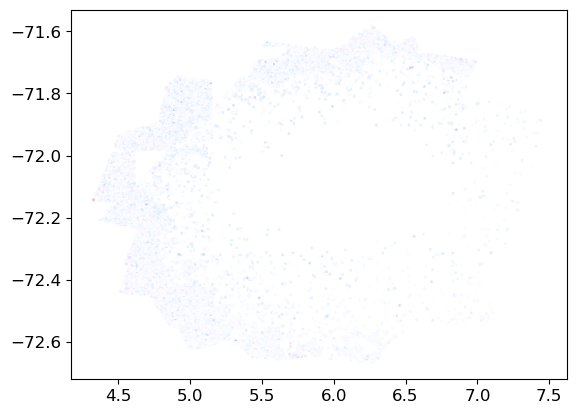

In [184]:
plt.scatter(objects[test]["coord_ra"], objects[test]["coord_dec"], s=1, c=colors[test])

(array([[0.0000e+00, 1.0000e+00, 1.0000e+00, 1.5000e+01, 3.9000e+01,
         1.4100e+02, 7.0800e+02, 2.4930e+03, 3.2160e+03, 1.2164e+04],
        [0.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 1.7000e+01,
         4.8000e+01, 1.1900e+02, 5.7100e+02, 4.0330e+03, 1.3983e+04],
        [1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 6.0000e+00, 2.4000e+01, 1.8745e+04]]),
 array([0.65451603, 0.68906443, 0.72361283, 0.75816122, 0.79270962,
        0.82725802, 0.86180641, 0.89635481, 0.93090321, 0.9654516 ,
        1.        ]),
 <a list of 3 BarContainer objects>)

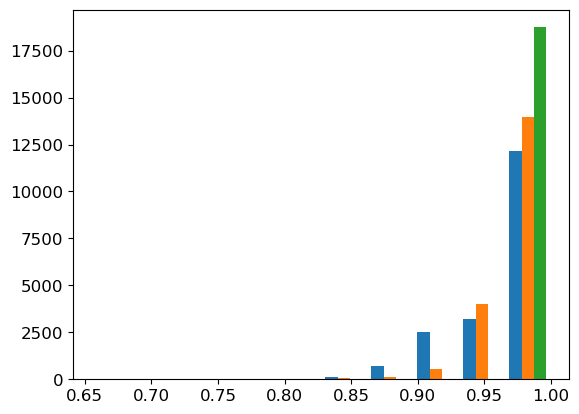

In [186]:
plt.hist(colors)

In [68]:
matplotlib.rcParams.update({'font.size': 12})

In [77]:
isochrones = astropy.io.ascii.read("data/tuc_iso.dat", format="csv", delimiter=" ", comment=None, header_start=13)
# there's one bad point here for some reason
isochrones = isochrones[isochrones["gmag"] < 30]

In [188]:
def plot_cmd(objects, mags, a, b, c, xlim=(-1.5, 4.5), dust_correct=True):
    """Plot a color-magnitude diagram for a-b vs. c."""
    kwargs = dict(s=1, alpha=.4)
    if dust_correct:
        y = mags[c] - dust.r_x[c] * objects['ebv']*u.ABmag
        x = (mags[a] - dust.r_x[a] * objects['ebv']*u.ABmag) - (mags[b] - dust.r_x[b] * objects['ebv']*u.ABmag)
    else:
        y = mags[c]
        x = mags[a] - mags[b]

    plt.scatter(x, y, **kwargs)
    
    plt.plot(isochrones[f"{a}mag"] - isochrones[f"{b}mag"], isochrones[f"{c}mag"] + modulus, color="black")

    plt.gca().invert_yaxis()
    plt.xlim(xlim)
    plt.ylim(26, 15)
    plt.xlabel(f"{a} - {b}")
    plt.ylabel(f"{c}")

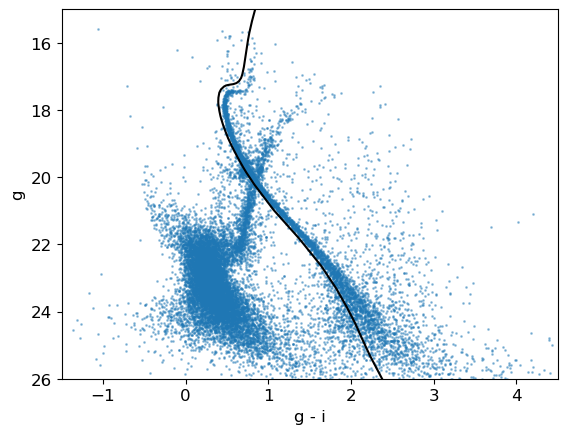

In [189]:
plot_cmd(objects, mags, "g", "i", "g")

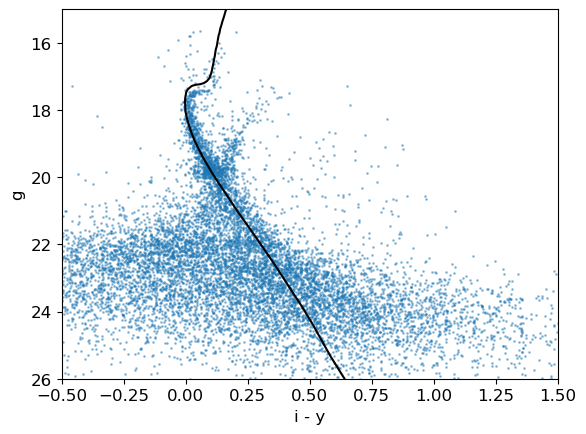

In [190]:
plot_cmd(objects, mags, "i", "y", "g", xlim=(-.5, 1.5))

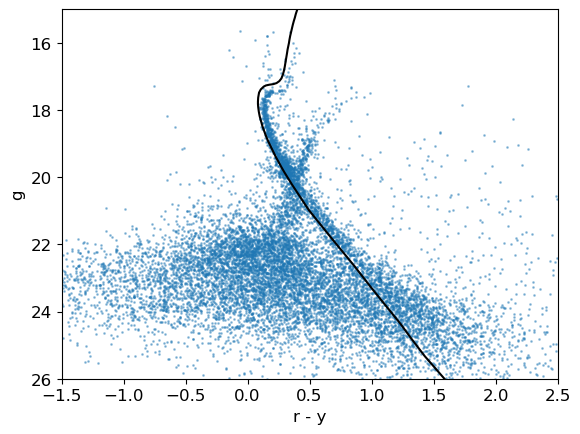

In [191]:
plot_cmd(objects, mags, "r", "y", "g", xlim=(-1.5, 2.5))

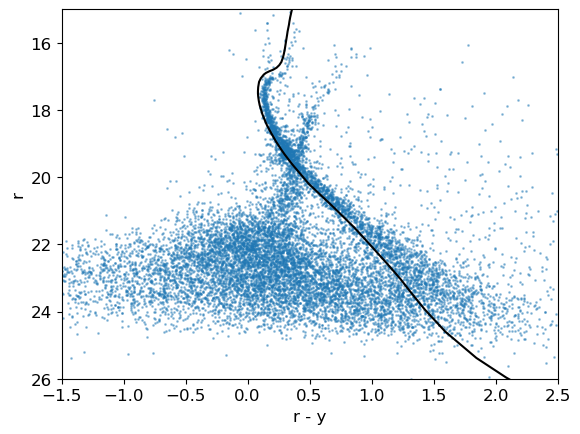

In [192]:
plot_cmd(objects, mags, "r", "y", "r", xlim=(-1.5, 2.5))